# Libraries

In [32]:
%load_ext autoreload
%autoreload 2

In [3]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import scorecardpy as sc
import random as rd
import re
from IPython.display import display
from matplotlib.backends.backend_pdf import PdfPages

# Data

In [73]:
# data prepare ------
# load germancredit data
smp_full = sc.germancredit()
smp_full['will_default'] = smp_full['creditability'].apply(lambda x: 1 if x == 'bad' else 0)
smp_full = smp_full.loc[:,smp_full.columns != 'creditability']
smp_full.loc[0:99, 'credit.amount'] = np.nan
smp_full.loc[0:99, 'purpose'] = np.nan
smp_full.head()

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,personal.status.and.sex,other.debtors.or.guarantors,...,property,age.in.years,other.installment.plans,housing,number.of.existing.credits.at.this.bank,job,number.of.people.being.liable.to.provide.maintenance.for,telephone,foreign.worker,will_default
0,... < 0 DM,6,critical account/ other credits existing (not ...,NaN,NaN,unknown/ no savings account,... >= 7 years,4,male : divorced/separated,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,NaN,NaN,... < 100 DM,1 <= ... < 4 years,2,male : divorced/separated,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,1
2,no checking account,12,critical account/ other credits existing (not ...,NaN,NaN,... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,... < 0 DM,42,existing credits paid back duly till now,NaN,NaN,... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,guarantor,...,building society savings agreement/ life insur...,45,none,for free,1,skilled employee / official,2,none,yes,0
4,... < 0 DM,24,delay in paying off in the past,NaN,NaN,... < 100 DM,1 <= ... < 4 years,3,male : divorced/separated,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,1


In [86]:
train, test = sc.split_df(smp_full, ratio=0.8).values()
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


In [51]:
for i in range(5):
    smp_full = pd.concat([smp_full, smp_full])
    
smp_full['RepDate_End'] = np.random.randint(1, 73, smp_full.shape[0])

sorted_date = sorted(smp_full['RepDate_End'].unique())
del sorted_date[-12:]
smp_dev = smp_full.loc[smp_full['RepDate_End'].isin(sorted_date)]
#smp_dev = smp_full.loc[smp_dev['prod_grp'] == 'Mortgage']
train, test = sc.split_df(smp_dev, ratio=0.8).values()
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

C:\Users\X250\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:58: UserWarning: There are duplicated index in dataset. The index has been reseted.
  warnings.warn('There are duplicated index in dataset. The index has been reseted.')


# 1. Preliminary analysis of variables (missings, outliers, concentration/distribution)

In [ ]:
# columns that are not variables
var_skip = ['will_default','RepDate_End']
# special values for numeric variables - TBD
spl_val = []
# list of variables by type (numeric variables with less than 10 unique values are considered as categorical)
var_cat, var_num = sc.var_types(train, var_skip)

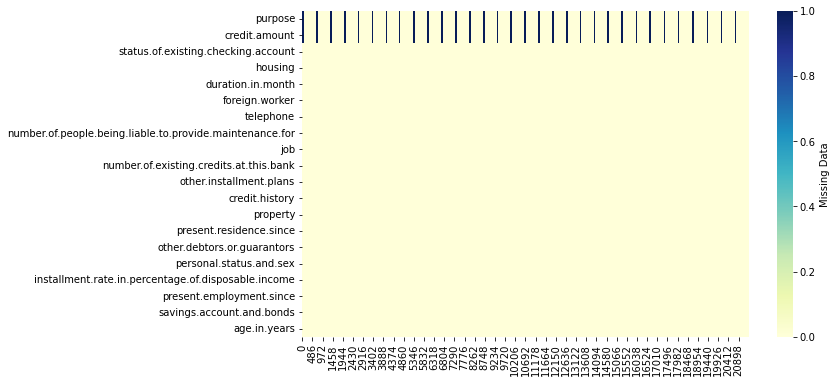

In [53]:
# heatmap for the missing values
percent_missing = train.loc[:, var_cat+var_num].isna().sum() * 100 / len(train)
percent_missing = pd.DataFrame({'column':percent_missing.index, 'percent_missing':percent_missing.values})
percent_missing.sort_values('percent_missing', ascending=False, inplace=True)
percent_missing.reset_index(drop=True)

plt.figure(figsize=(10,6))
sns.heatmap(train[percent_missing.column].isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("1_1_missings_heatmap.png", dpi=100, bbox_inches = "tight")

In [54]:
#round missings
#thresholds as params
# warning checks
var_cat_summary, var_num_summary = sc.var_pre_analysis(train, var_cat, var_num, spl_val, hhi_low=0.05, hhi_high=0.95, min_share=0.05)

writer = pd.ExcelWriter('1_2_preliminary_analysis.xlsx', engine='xlsxwriter')
var_cat_summary.to_excel(writer, sheet_name='var_cat_summary')
var_num_summary.to_excel(writer, sheet_name='var_num_summary')
writer.save()

display(var_cat_summary)
display(var_num_summary)

,Variable,HHI,Min share,Missings share,HHI warning,Min share warning,Missings warning
0,status.of.existing.checking.account,0.3056,0.0644,0.0000,,,
1,credit.history,0.3787,0.0401,0.0000,,Min share is 4.01%,
2,purpose,0.1644,0.0101,0.1021,,Min share is 1.01%,10.21% missing values
3,savings.account.and.bonds,0.4173,0.0477,0.0000,,Min share is 4.77%,
4,present.employment.since,0.2430,0.0615,0.0000,,,
5,installment.rate.in.percentage.of.disposable.i...,0.3229,0.1355,0.0000,,,
6,personal.status.and.sex,0.4068,0.0000,0.0000,,Min share is 0.0%,
7,other.debtors.or.guarantors,0.8276,0.0412,0.0000,,Min share is 4.12%,
8,present.residence.since,0.3053,0.1304,0.0000,,,
9,property,0.2672,0.1566,0.0000,,,


,Variable,Q1,Median,Q3,Lower whisker,Upper whisker,Share of outliers,Missings share,Outliers warning,Missings warning
0,duration.in.month,12.0,18.0,24.0,4.0,60.0,0.0010,0.0000,0.1% outliers,
1,credit.amount,1361.0,2323.0,3913.0,250.0,11560.0,0.0221,0.1021,2.21% outliers,10.21% missing values
2,age.in.years,27.0,33.0,42.0,19.0,75.0,0.0000,0.0000,,


In [ ]:
#treatment of nan
'''
for var, dt in smp_full.dtypes.items():
    print(var)
    print(dt)
    if var not in var_skip:
        if dt.name == 'category':
            smp_full[var] = smp_full[var].cat.add_categories('missing').fillna('missing')
        if dt.name == 'object':
            smp_full[var] = smp_full[var].fillna('missing')
'''

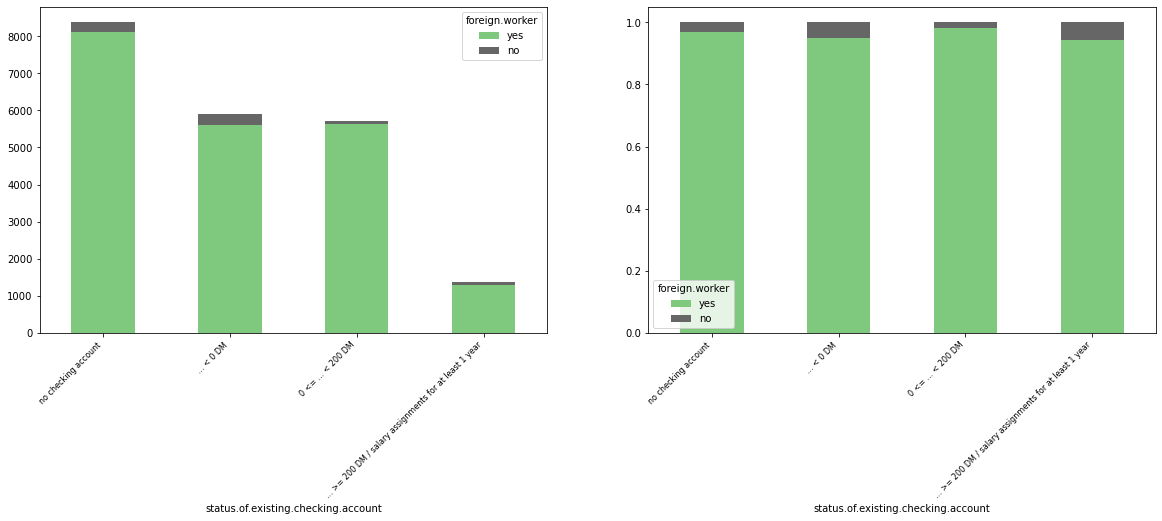

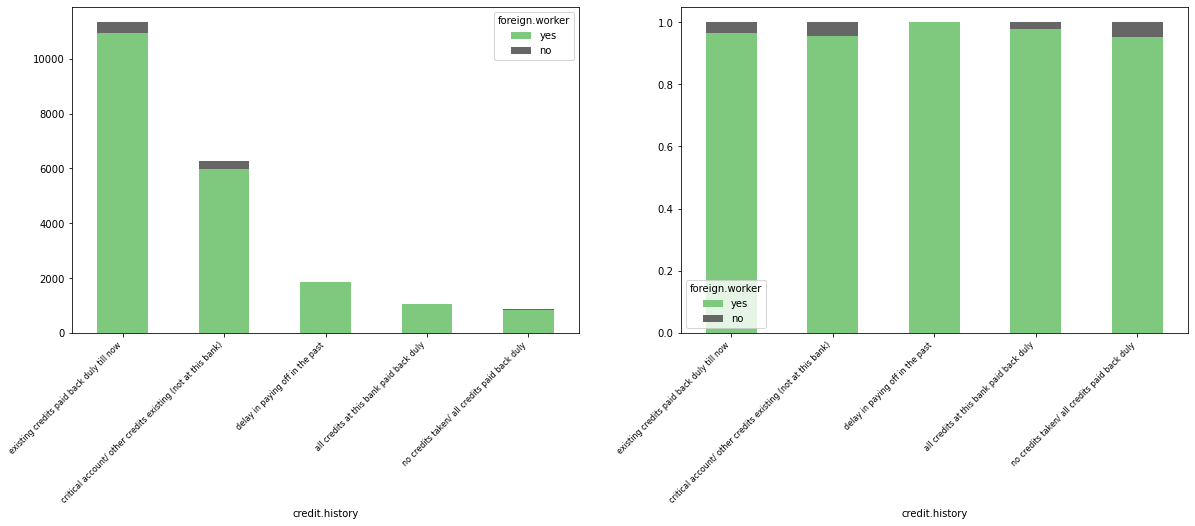

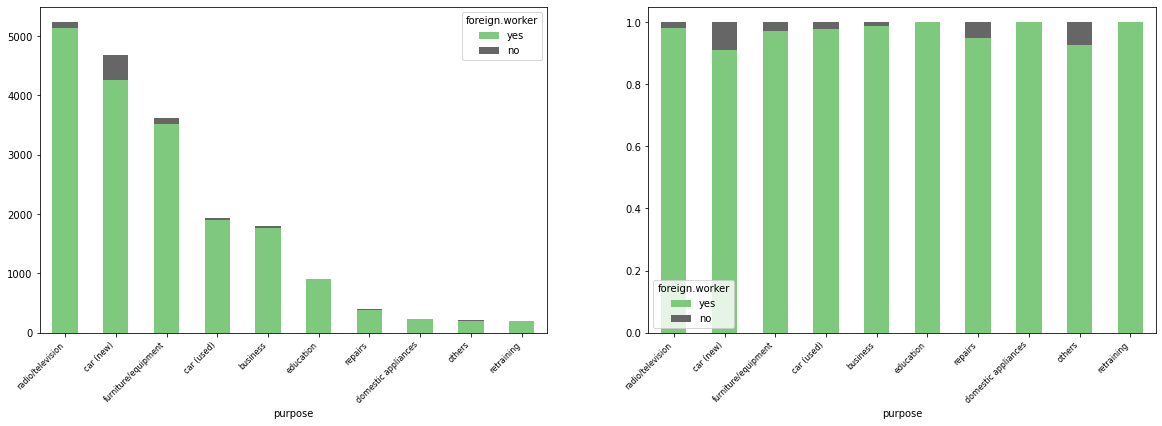

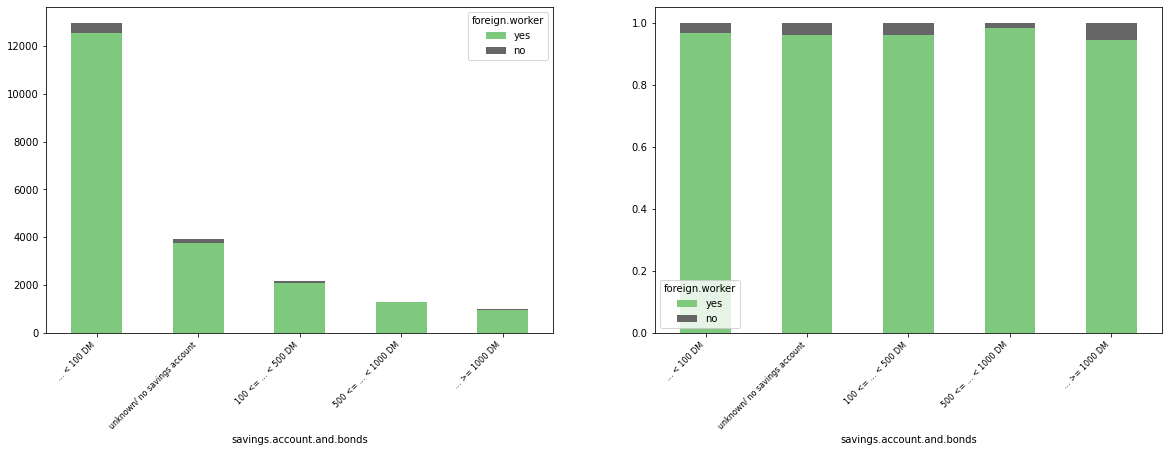

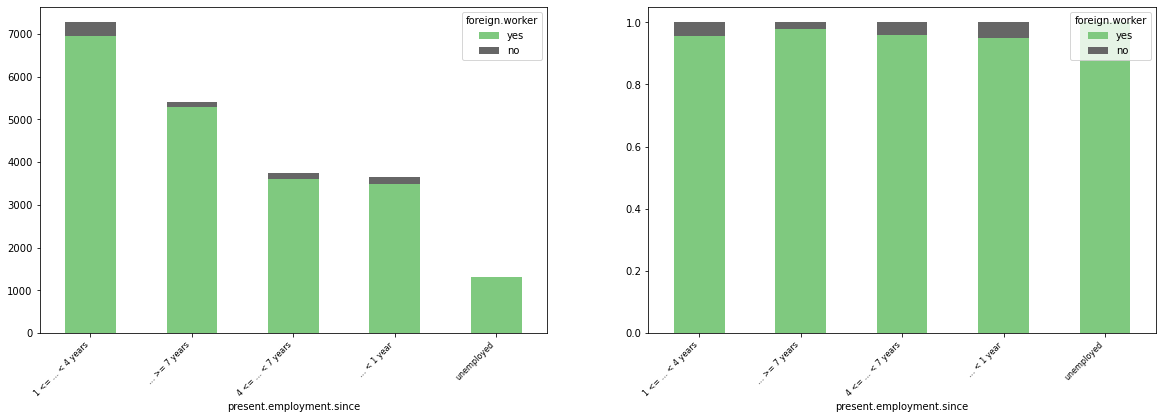

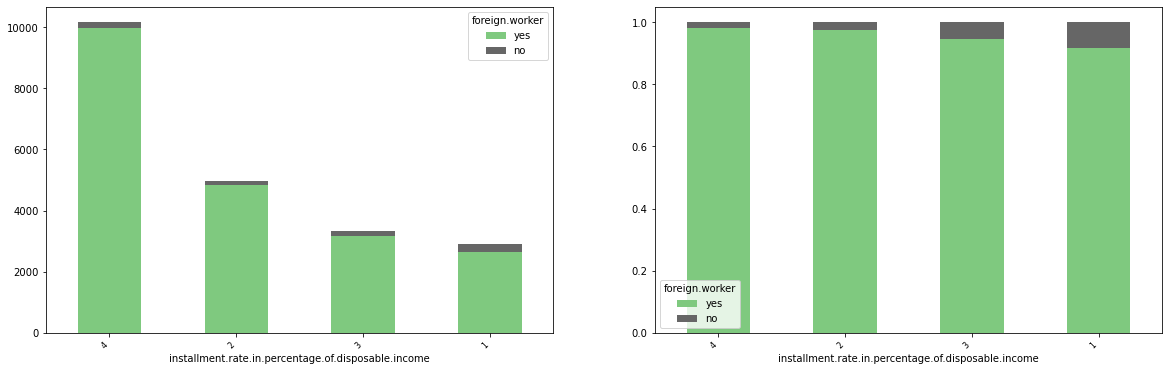

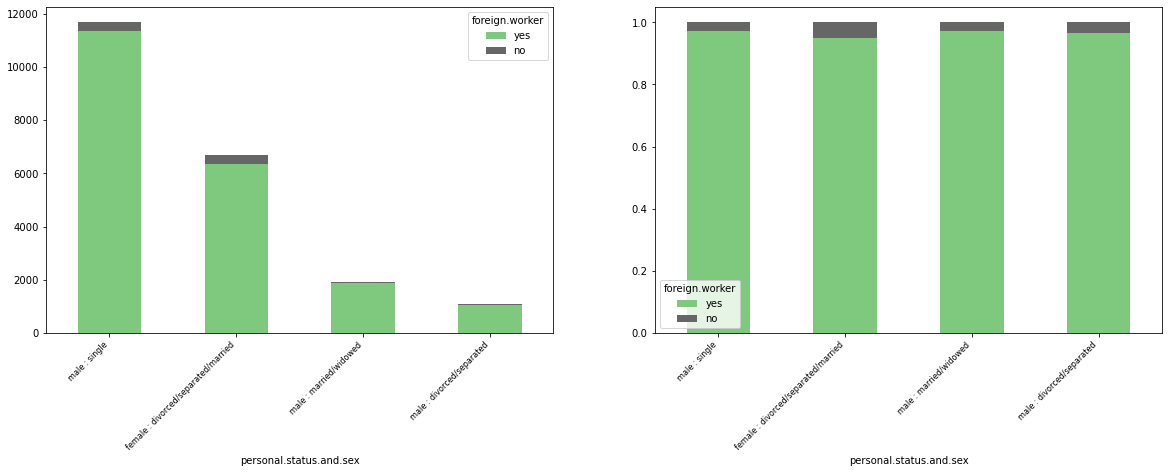

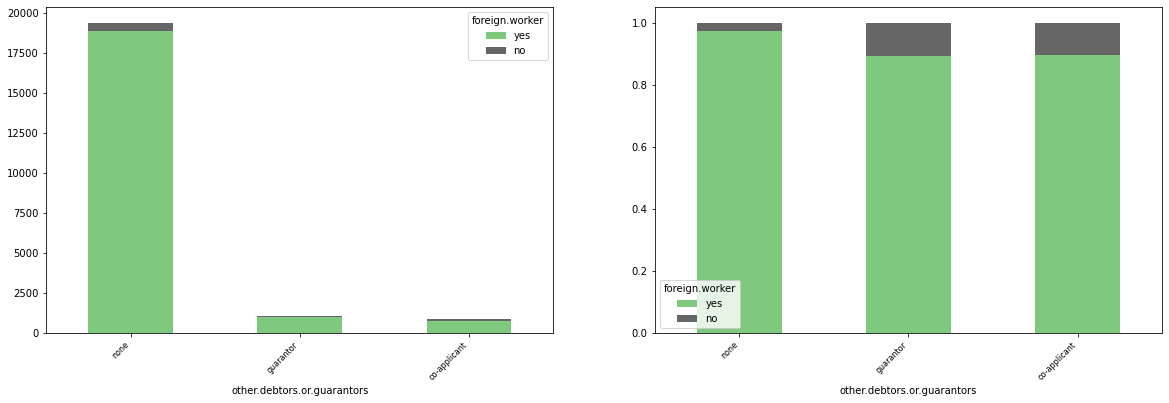

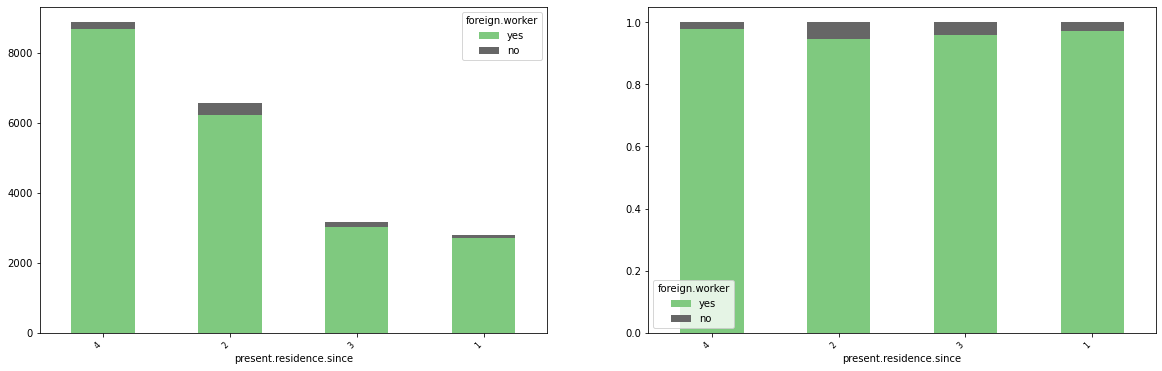

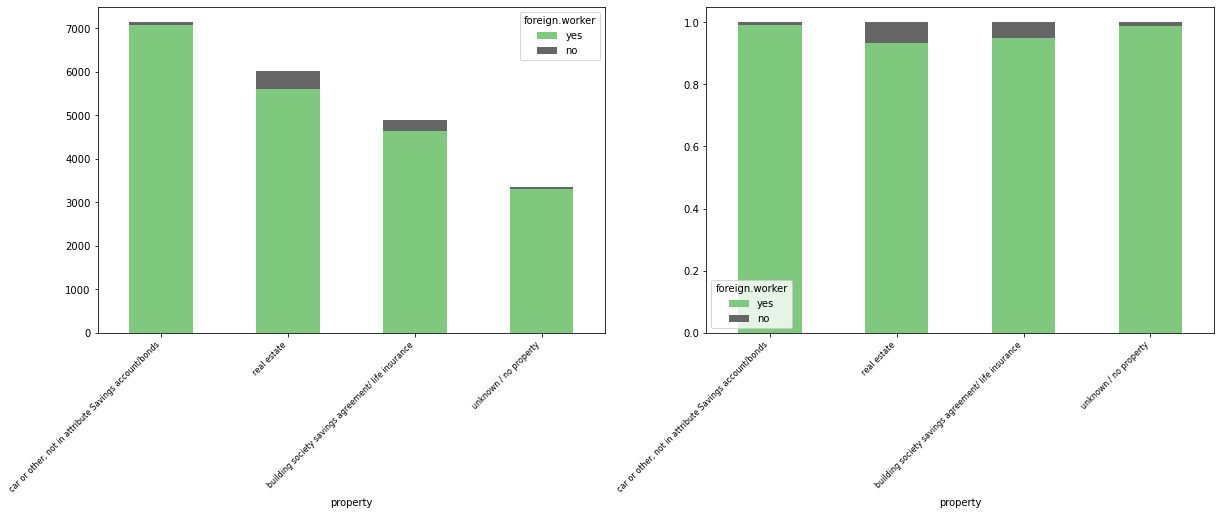

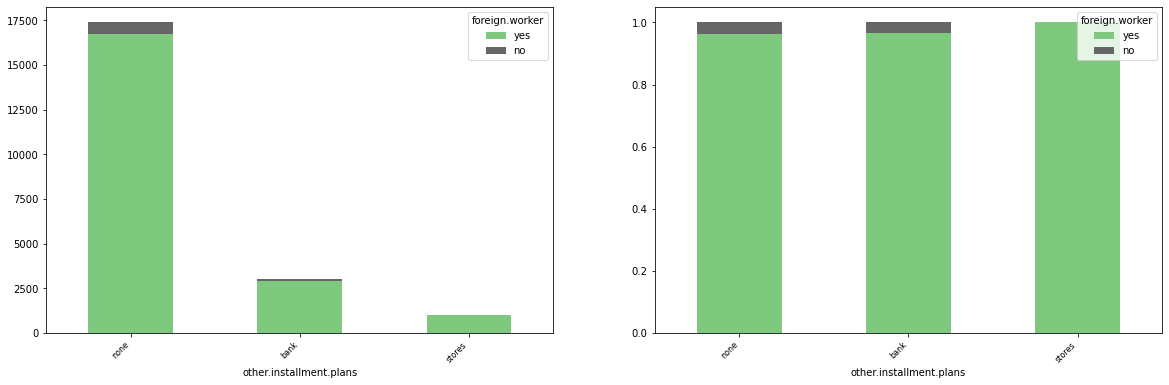

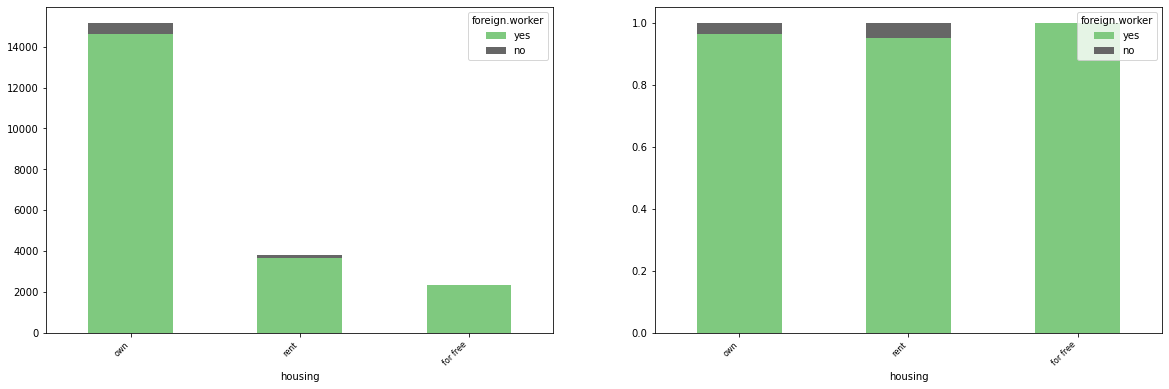

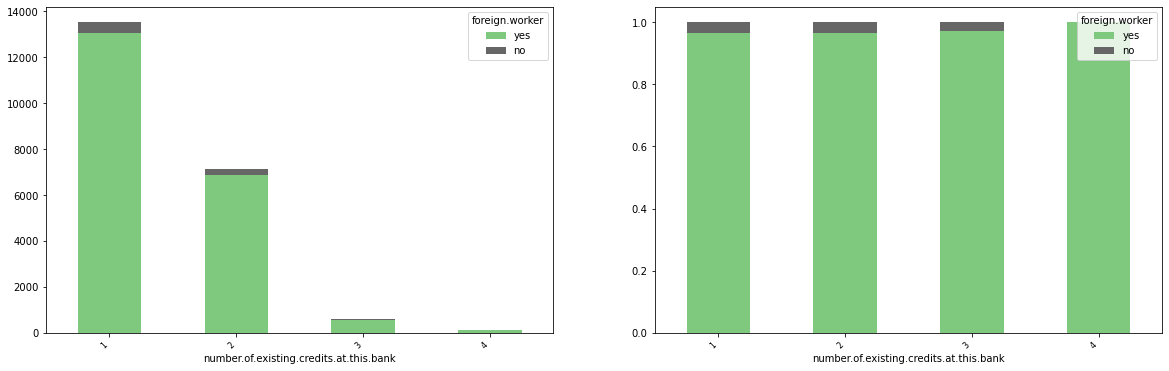

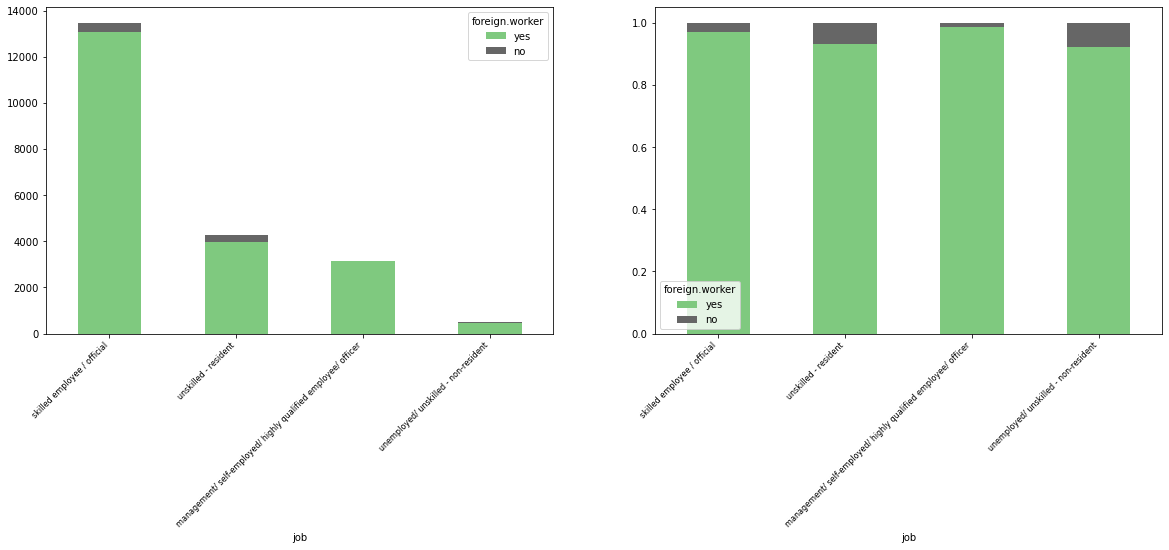

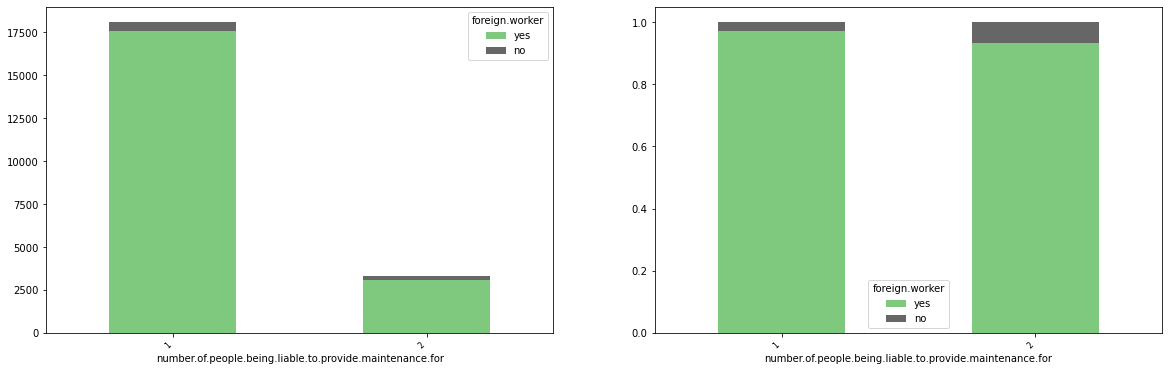

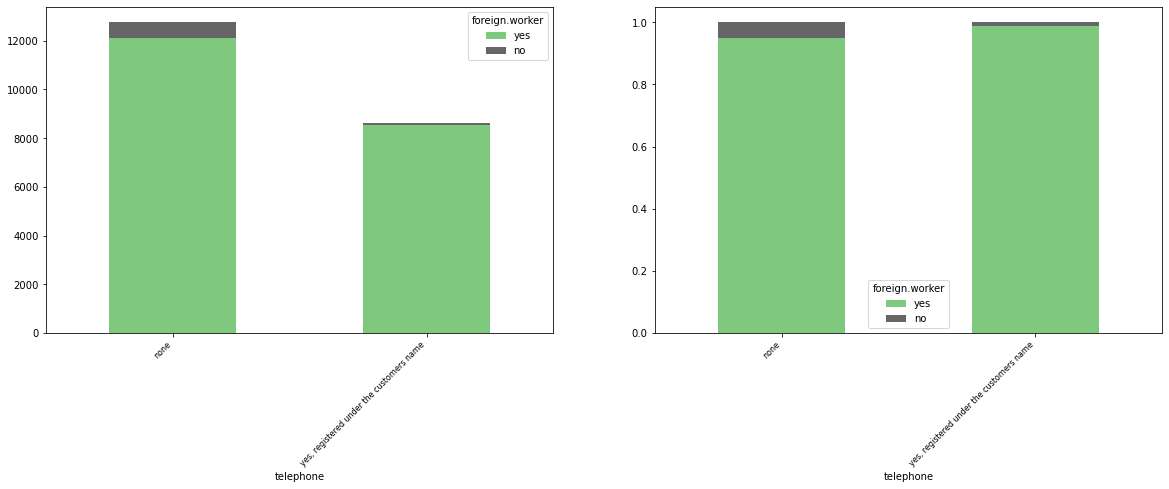

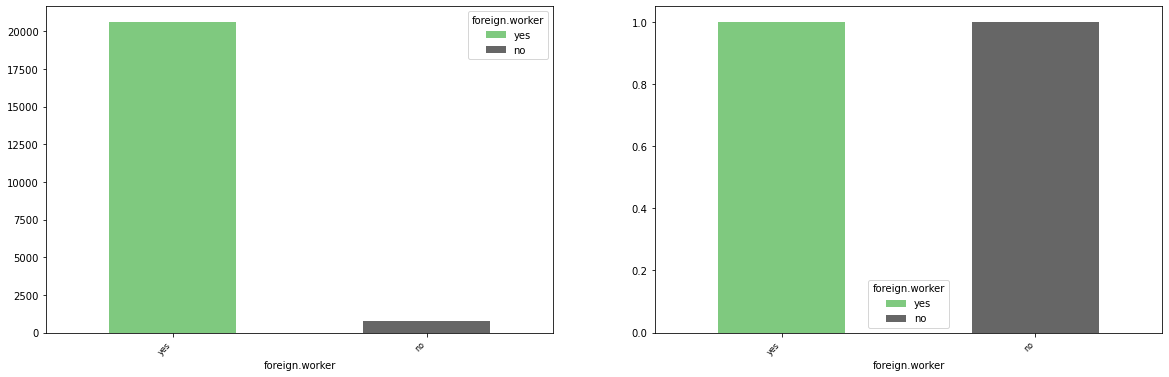

In [55]:
# distribution for categorical variables with extract to pdf
sc.var_cat_distr(train, var_cat, '1_3_categorical_vars_distribution.pdf', groupby='foreign.worker')

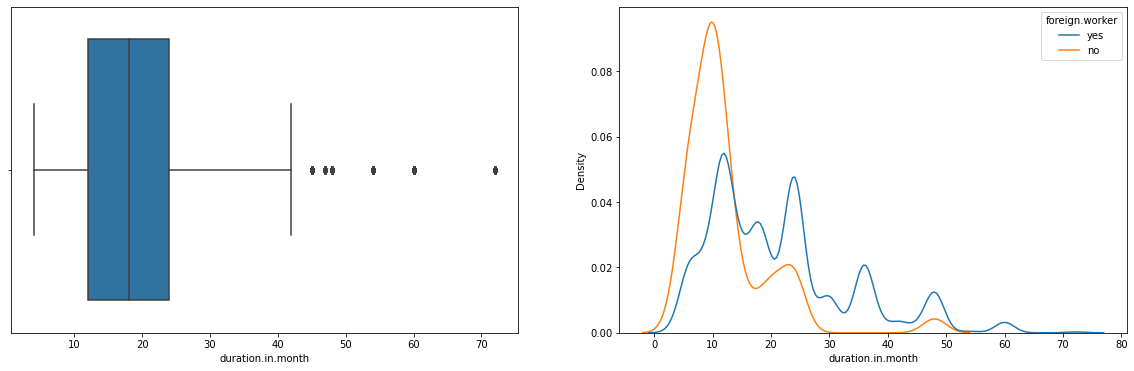

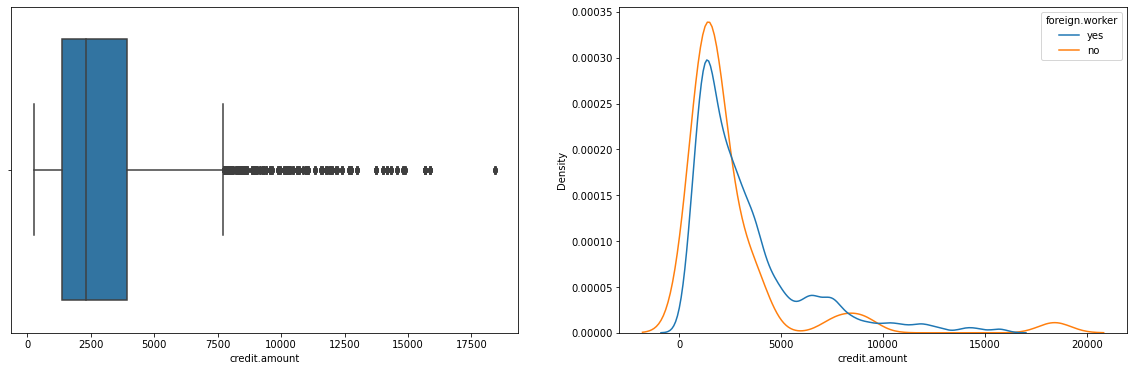

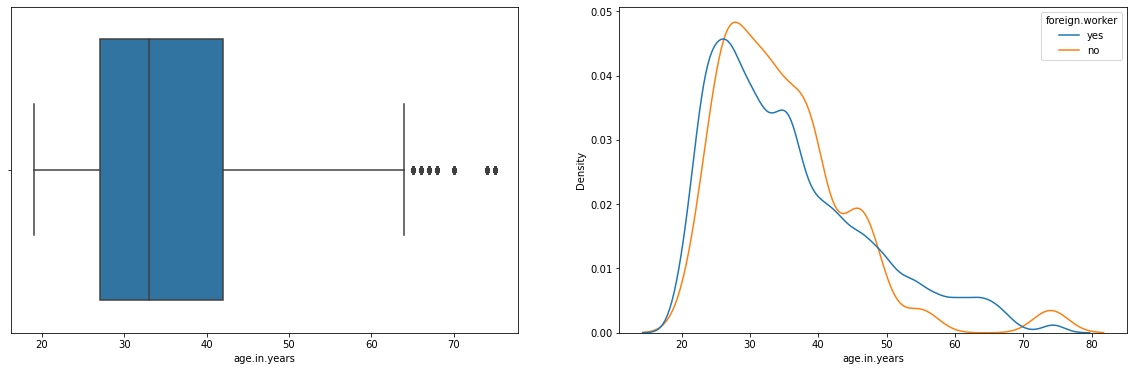

In [56]:
sc.var_num_distr(train, var_num, '1_4_numerical_vars_distribution.pdf', groupby='foreign.worker')

In [ ]:
'''
Missing values on the charts
Check distribution over time
'''

# 2. Automated binning

In [87]:
# binning
fine_class, coarse_class = sc.woebin(train, y = 'will_default', x = var_cat + var_num, init_count_distr = 0.05)


[INFO] creating woe binning ...


In [ ]:
'''
# replacing intervals by bin bumber in fine classing table (for better visibility)
bestbreaks_i = pd.to_numeric(coarse_class['credit.amount']['breaks0'])
bestbreaks_i = bestbreaks_i.append(pd.to_numeric(pd.Series('inf')), ignore_index=True)
fine_class['credit.amount']['bin'] = pd.cut(fine_class['credit.amount']['brkp'], bestbreaks_i, right=False, \
                                           labels = list(range(1, len(coarse_class['credit.amount']['bin'])+1)))
'''

In [58]:
# extracting binning results to excel
pd.concat(fine_class.values()).reset_index(drop=True).to_excel('2_1_fine_classing.xlsx')
pd.concat(coarse_class.values()).reset_index(drop=True).to_excel('2_2_coarse_classing_auto.xlsx')

'''
# each variable on a different sheet
def binning_export(binning_dict):
    writer = pd.ExcelWriter('2_1_fine_classing.xlsx', engine='xlsxwriter')
    for x_i in binning_dict:
        binning_dict[x_i].to_excel(writer, sheet_name=x_i[0:30])
    writer.save()
    return
binning_export(fine_class)
'''

"\n# each variable on a different sheet\ndef binning_export(binning_dict):\n    writer = pd.ExcelWriter('2_1_fine_classing.xlsx', engine='xlsxwriter')\n    for x_i in binning_dict:\n        binning_dict[x_i].to_excel(writer, sheet_name=x_i[0:30])\n    writer.save()\n    return\nbinning_export(fine_class)\n"

In [26]:
fine_class['credit.amount']

720

In [ ]:
fine_class['status.of.existing.checking.account']

In [27]:
display(coarse_class['credit.amount'])
display(coarse_class['purpose'])

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks0,breaks,is_special_values
0,credit.amount,missing,80,0.100,59,21,0.262500,-0.167796,0.002716,0.172886,missing,missing,True
1,credit.amount,"[-inf,1371.75)",180,0.225,121,59,0.327778,0.146966,0.005001,0.172886,-inf,1371.75,False
2,credit.amount,"[1371.75,1676.5)",72,0.090,59,13,0.180556,-0.647369,0.032332,0.172886,1371.75,1676.5,False
3,credit.amount,"[1676.5,2644.95)",144,0.180,102,42,0.291667,-0.022084,0.000087,0.172886,1676.5,2644.95,False
4,credit.amount,"[2644.95,3234.35)",72,0.090,56,16,0.222222,-0.387543,0.012385,0.172886,2644.95,3234.35,False
5,credit.amount,"[3234.35,3962.25)",72,0.090,60,12,0.166667,-0.744218,0.041631,0.172886,3234.35,3962.25,False
6,credit.amount,"[3962.25,7181.9)",108,0.135,69,39,0.361111,0.294675,0.012376,0.172886,3962.25,7181.9,False
7,credit.amount,"[7181.9,inf)",72,0.090,37,35,0.486111,0.809650,0.066359,0.172886,7181.9,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks0,breaks,is_special_values
0,purpose,missing,80,0.10000,59,21,0.262500,-0.167796,0.002716,0.163218,missing,missing,True
1,purpose,"retraining%,%car (used)%,%radio/television",273,0.34125,220,53,0.194139,-0.558116,0.093281,0.163218,"retraining%,%car (used)%,%radio/television","retraining%,%car (used)%,%radio/television",False
2,purpose,"domestic appliances%,%business%,%furniture/equ...",396,0.49500,256,140,0.353535,0.261684,0.035592,0.163218,"domestic appliances%,%business%,%furniture/equ...","domestic appliances%,%business%,%furniture/equ...",False
3,purpose,"repairs%,%education",51,0.06375,28,23,0.450980,0.668509,0.031629,0.163218,"repairs%,%education","repairs%,%education",False


In [88]:
# iv for variables after automated binning
coarse_class_iv = sc.vars_iv(var_cat + var_num, coarse_class)

In [89]:
coarse_class_iv

,variable,iv
0,status.of.existing.checking.account,0.6252
1,credit.history,0.3275
2,duration.in.month,0.3166
3,savings.account.and.bonds,0.2603
4,credit.amount,0.1729
5,purpose,0.1528
6,property,0.1502
7,age.in.years,0.1129
8,housing,0.1026
9,present.employment.since,0.0965


{'status.of.existing.checking.account': <Figure size 432x288 with 2 Axes>,
 'credit.history': <Figure size 432x288 with 2 Axes>,
 'purpose': <Figure size 432x288 with 2 Axes>,
 'savings.account.and.bonds': <Figure size 432x288 with 2 Axes>,
 'present.employment.since': <Figure size 432x288 with 2 Axes>,
 'installment.rate.in.percentage.of.disposable.income': <Figure size 432x288 with 2 Axes>,
 'personal.status.and.sex': <Figure size 432x288 with 2 Axes>,
 'other.debtors.or.guarantors': <Figure size 432x288 with 2 Axes>,
 'present.residence.since': <Figure size 432x288 with 2 Axes>,
 'property': <Figure size 432x288 with 2 Axes>,
 'other.installment.plans': <Figure size 432x288 with 2 Axes>,
 'housing': <Figure size 432x288 with 2 Axes>,
 'number.of.existing.credits.at.this.bank': <Figure size 432x288 with 2 Axes>,
 'job': <Figure size 432x288 with 2 Axes>,
 'number.of.people.being.liable.to.provide.maintenance.for': <Figure size 432x288 with 2 Axes>,
 'telephone': <Figure size 432x288 

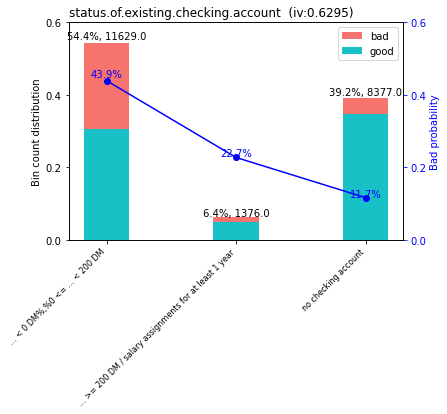

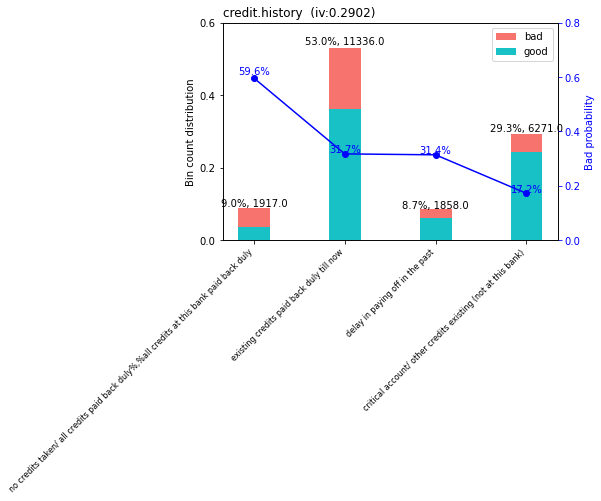

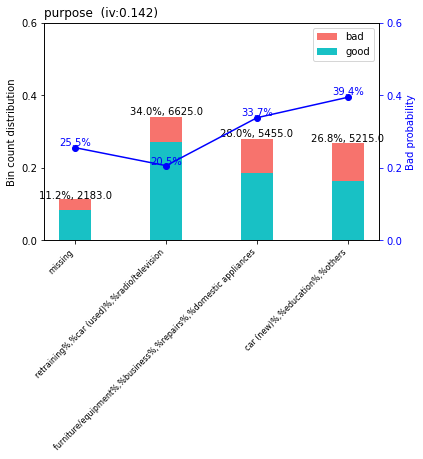

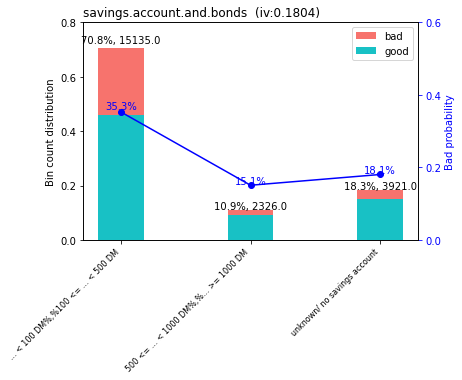

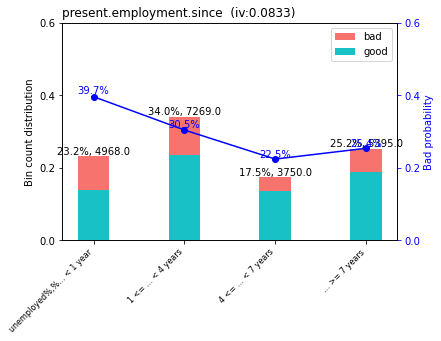

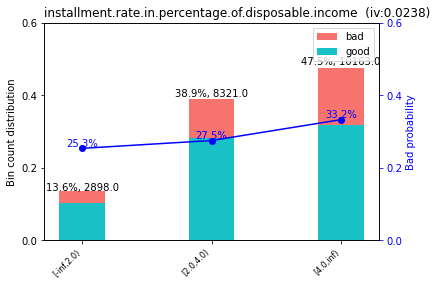

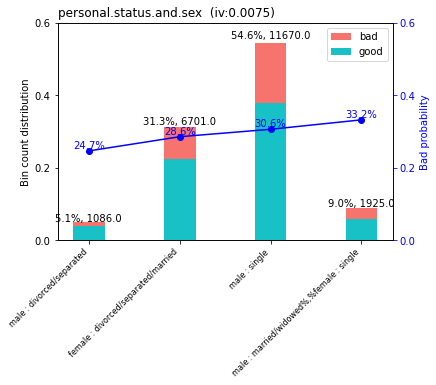

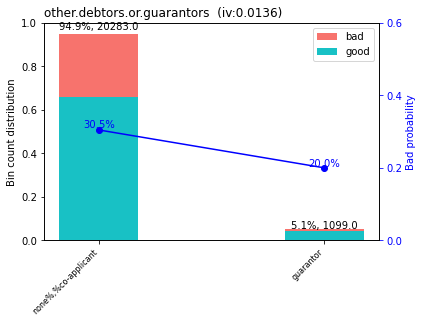

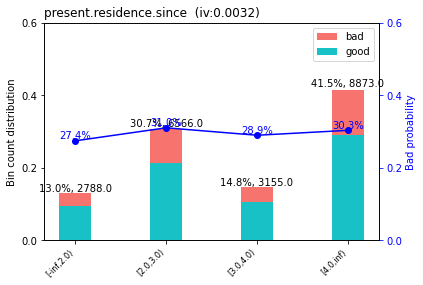

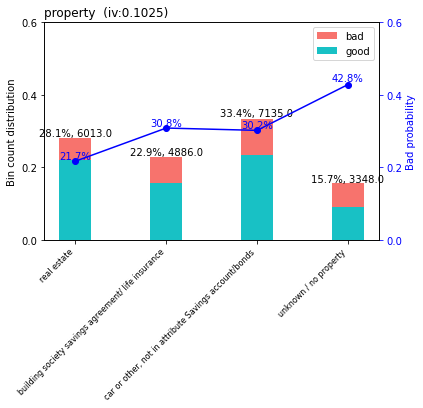

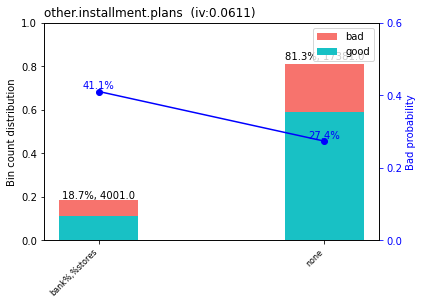

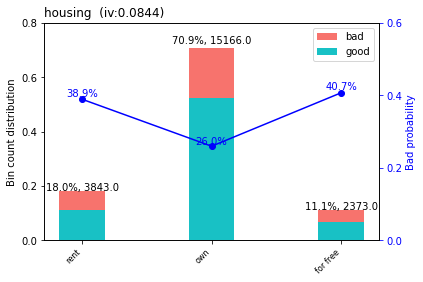

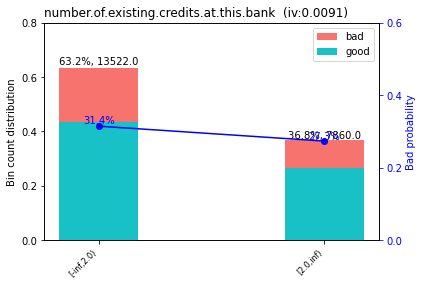

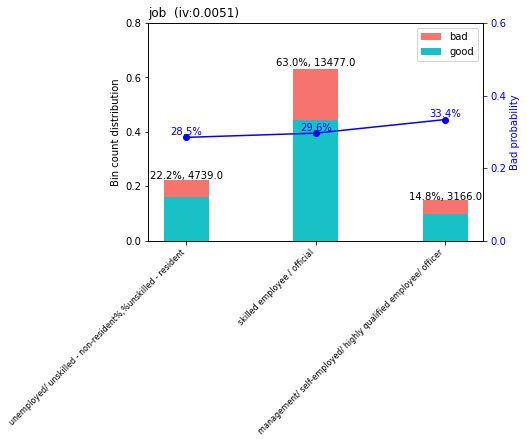

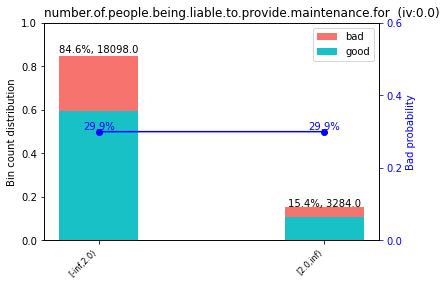

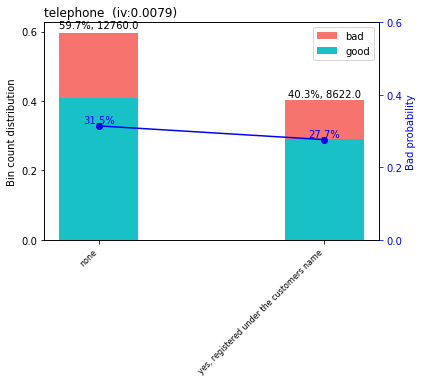

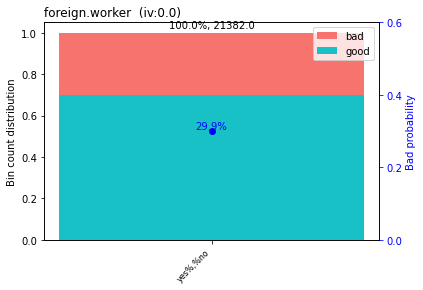

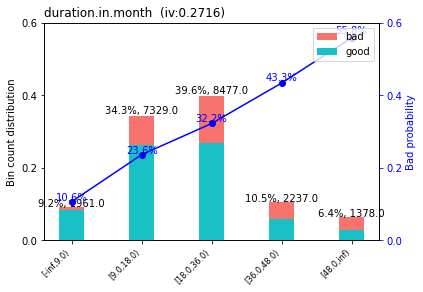

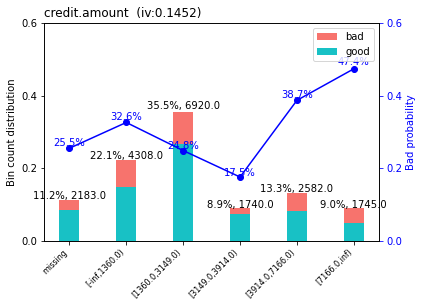

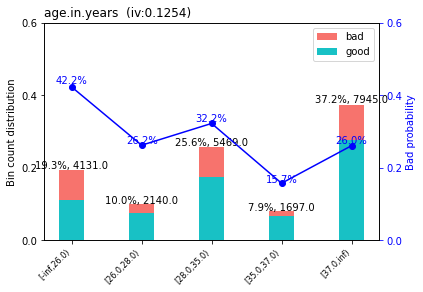

In [61]:
# binning visualization
sc.woebin_plot(coarse_class)

# 3. Binning adjustments 

-------- 1/20 status.of.existing.checking.account --------


,variable,bin,brkp,good,bad,badprob
0,status.of.existing.checking.account,... < 0 DM,0,116.0,105.0,0.475113
1,status.of.existing.checking.account,0 <= ... < 200 DM,1,134.0,86.0,0.390909
2,status.of.existing.checking.account,... >= 200 DM / salary assignments for at leas...,2,41.0,11.0,0.211538
3,status.of.existing.checking.account,no checking account,3,272.0,35.0,0.114007
4,status.of.existing.checking.account,missing,4,NaN,NaN,NaN


>>> Current breaks:
'... < 0 DM%,%0 <= ... < 200 DM','... >= 200 DM / salary assignments for at least 1 year','no checking account%,%missing' 



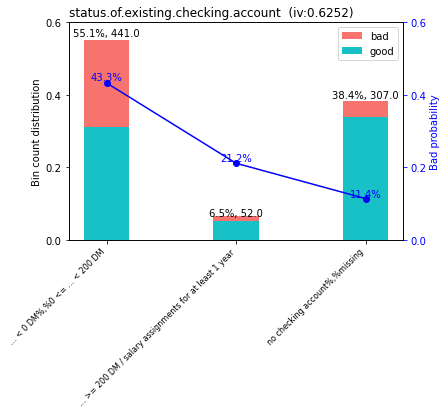

>>> Adjust breaks for (1/20) status.of.existing.checking.account?
1: next 
2: yes 
3: back


KeyboardInterrupt: Interrupted by user

In [91]:
# manual review and adjustment of binning
breaks_list = sc.woebin_adj(train, y="will_default", bins=coarse_class, fine_bins=fine_class, adj_all_var=True)

In [63]:
# update of coarse classing table (fine classing is relevant only for automated binning)
fine_class_adj, coarse_class_adj = sc.woebin(train, y = 'will_default', x = var_cat + var_num, breaks_list = breaks_list, init_count_distr = 0.02)

[INFO] creating woe binning ...


-------- 1/12 age.in.years --------


,brkp,variable,bin,good,bad,badprob
0,-inf,age.in.years,"[-inf,22.0)",401,243,0.377329
1,22.0,age.in.years,"[22.0,23.0)",349,239,0.406463
2,23.0,age.in.years,"[23.0,24.0)",608,432,0.415385
3,24.0,age.in.years,"[24.0,26.0)",1028,831,0.447015
4,26.0,age.in.years,"[26.0,27.0)",775,282,0.266793
5,27.0,age.in.years,"[27.0,28.0)",805,278,0.256694
6,28.0,age.in.years,"[28.0,29.0)",598,322,0.350000
7,29.0,age.in.years,"[29.0,30.0)",476,303,0.388960
8,30.0,age.in.years,"[30.0,31.0)",658,239,0.266444
9,31.0,age.in.years,"[31.0,33.0)",1100,411,0.272005


>>> Current breaks:
26.0,28.0,35.0,37.0 



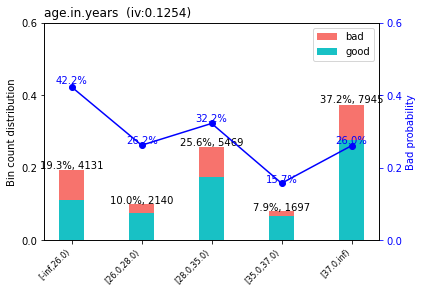

>>> Adjust breaks for (1/12) age.in.years?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/12 credit.amount --------


,brkp,variable,bin,good,bad,badprob
0,-inf,credit.amount,"[-inf,707.0)",619,244,0.282735
1,707.0,credit.amount,"[707.0,929.0)",534,332,0.383372
2,929.0,credit.amount,"[929.0,1126.0)",601,231,0.277644
3,1126.0,credit.amount,"[1126.0,1257.4)",578,320,0.356347
4,1257.4,credit.amount,"[1257.4,1360.0)",572,277,0.326266
5,1360.0,credit.amount,"[1360.0,1478.0)",664,180,0.213270
6,1478.0,credit.amount,"[1478.0,1601.5)",721,180,0.199778
7,1601.5,credit.amount,"[1601.5,1893.0)",621,229,0.269412
8,1893.0,credit.amount,"[1893.0,2101.0)",623,247,0.283908
9,2101.0,credit.amount,"[2101.0,2325.0)",625,246,0.282434


>>> Current breaks:
1360.0,3149.0,3914.0,7166.0,nan 



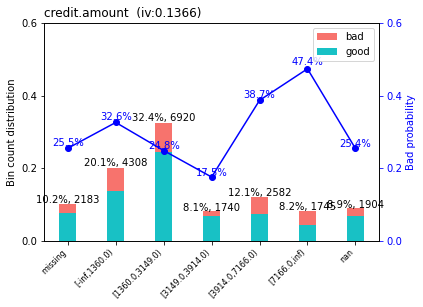

>>> Adjust breaks for (2/12) credit.amount?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/12 credit.history --------


,variable,bin,brkp,good,bad,badprob
0,credit.history,no credits taken/ all credits paid back duly,0,323,535,0.623543
1,credit.history,all credits at this bank paid back duly,1,451,608,0.574127
2,credit.history,existing credits paid back duly till now,2,7740,3596,0.317219
3,credit.history,delay in paying off in the past,3,1275,583,0.313778
4,credit.history,critical account/ other credits existing (not ...,4,5193,1078,0.171902


>>> Current breaks:
'no credits taken/ all credits paid back duly%,%all credits at this bank paid back duly','existing credits paid back duly till now','delay in paying off in the past','critical account/ other credits existing (not at this bank)' 



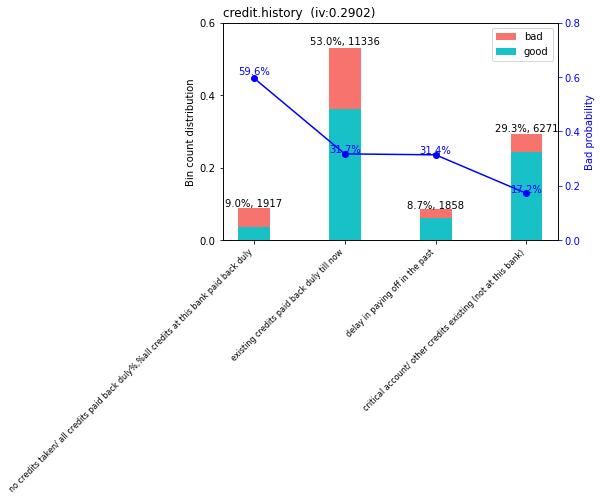

>>> Adjust breaks for (3/12) credit.history?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/12 duration.in.month --------


,brkp,variable,bin,good,bad,badprob
0,-inf,duration.in.month,"[-inf,9.0)",1753,208,0.106068
1,9.0,duration.in.month,"[9.0,10.0)",774,299,0.278658
2,10.0,duration.in.month,"[10.0,12.0)",724,68,0.085859
3,12.0,duration.in.month,"[12.0,15.0)",2956,1095,0.270304
4,15.0,duration.in.month,"[15.0,18.0)",1148,265,0.187544
5,18.0,duration.in.month,"[18.0,20.0)",1502,921,0.380107
6,20.0,duration.in.month,"[20.0,24.0)",633,207,0.246429
7,24.0,duration.in.month,"[24.0,30.0)",2994,1306,0.303721
8,30.0,duration.in.month,"[30.0,36.0)",621,293,0.320569
9,36.0,duration.in.month,"[36.0,48.0)",1268,969,0.433169


>>> Current breaks:
9.0,18.0,36.0,48.0 



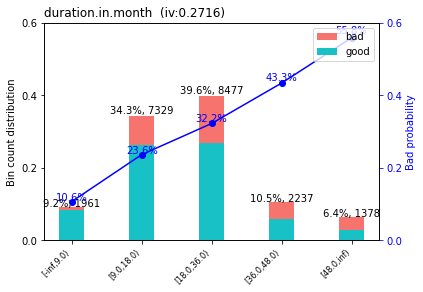

>>> Adjust breaks for (4/12) duration.in.month?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/12 installment.rate.in.percentage.of.disposable.income --------


,variable,bin,brkp,good,bad,badprob
0,installment.rate.in.percentage.of.disposable.i...,"[-inf,2.0)",-inf,2164,734,0.253278
1,installment.rate.in.percentage.of.disposable.i...,"[2.0,3.0)",2.0,3639,1341,0.269277
2,installment.rate.in.percentage.of.disposable.i...,"[3.0,4.0)",3.0,2395,946,0.283149
3,installment.rate.in.percentage.of.disposable.i...,"[4.0,inf)",4.0,6784,3379,0.332481


>>> Current breaks:
2.0,4.0 



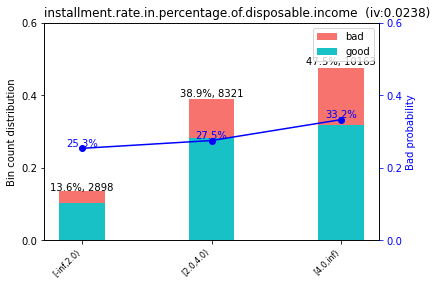

>>> Adjust breaks for (5/12) installment.rate.in.percentage.of.disposable.income?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/12 number.of.existing.credits.at.this.bank --------


,variable,bin,brkp,good,bad,badprob
0,number.of.existing.credits.at.this.bank,"[-inf,2.0)",-inf,9270,4252,0.314451
1,number.of.existing.credits.at.this.bank,"[2.0,4.0)",2.0,5623,2109,0.272763
2,number.of.existing.credits.at.this.bank,"[4.0,inf)",4.0,89,39,0.304688


>>> Current breaks:
2.0 



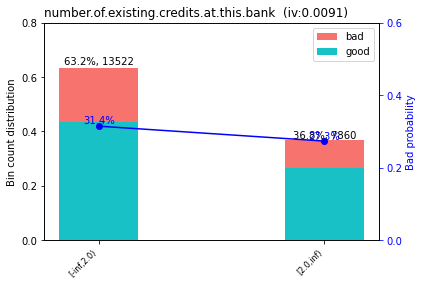

>>> Adjust breaks for (6/12) number.of.existing.credits.at.this.bank?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/12 number.of.people.being.liable.to.provide.maintenance.for --------


,variable,bin,brkp,good,bad,badprob
0,number.of.people.being.liable.to.provide.maint...,"[-inf,2.0)",-inf,12681,5417,0.299315
1,number.of.people.being.liable.to.provide.maint...,"[2.0,inf)",2.0,2301,983,0.299330


>>> Current breaks:
2.0 



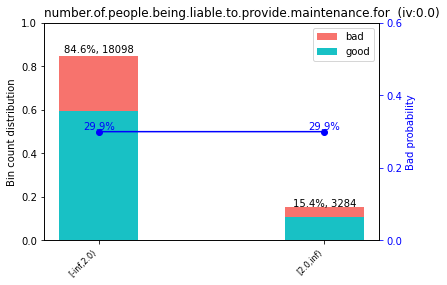

>>> Adjust breaks for (7/12) number.of.people.being.liable.to.provide.maintenance.for?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/12 personal.status.and.sex --------


,variable,bin,brkp,good,bad,badprob
0,personal.status.and.sex,male : divorced/separated,0,818.0,268.0,0.246777
1,personal.status.and.sex,female : divorced/separated/married,1,4785.0,1916.0,0.285927
2,personal.status.and.sex,male : single,2,8094.0,3576.0,0.306427
3,personal.status.and.sex,male : married/widowed,3,1285.0,640.0,0.332468
4,personal.status.and.sex,female : single,4,NaN,NaN,NaN


>>> Current breaks:
'male : divorced/separated','female : divorced/separated/married','male : single','male : married/widowed%,%female : single' 



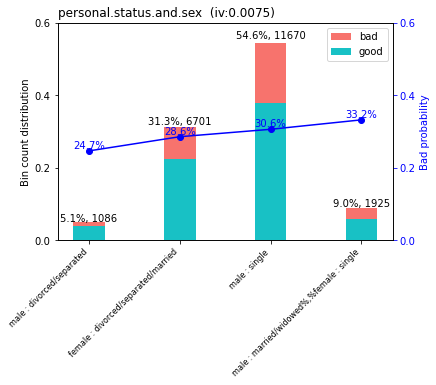

>>> Adjust breaks for (8/12) personal.status.and.sex?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/12 present.employment.since --------


,variable,bin,brkp,good,bad,badprob
0,present.employment.since,unemployed,0,838,476,0.362253
1,present.employment.since,... < 1 year,1,2159,1495,0.409141
2,present.employment.since,1 <= ... < 4 years,2,5054,2215,0.304719
3,present.employment.since,4 <= ... < 7 years,3,2908,842,0.224533
4,present.employment.since,... >= 7 years,4,4023,1372,0.254310


>>> Current breaks:
'unemployed%,%... < 1 year','1 <= ... < 4 years','4 <= ... < 7 years','... >= 7 years' 



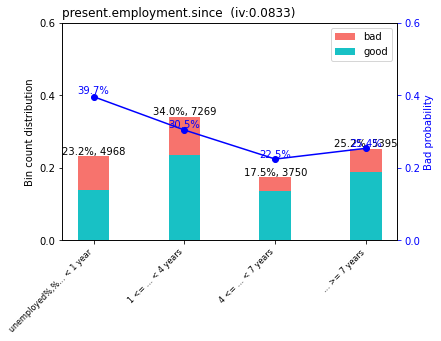

>>> Adjust breaks for (9/12) present.employment.since?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/12 present.residence.since --------


,variable,bin,brkp,good,bad,badprob
0,present.residence.since,"[-inf,2.0)",-inf,2024,764,0.274032
1,present.residence.since,"[2.0,3.0)",2.0,4531,2035,0.309930
2,present.residence.since,"[3.0,4.0)",3.0,2242,913,0.289382
3,present.residence.since,"[4.0,inf)",4.0,6185,2688,0.302942


>>> Current breaks:
2.0,3.0,4.0 



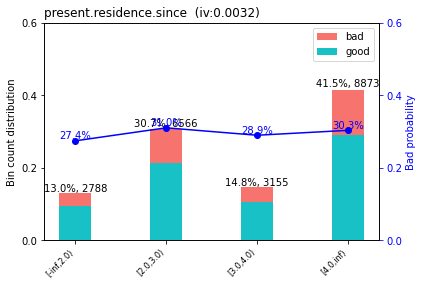

>>> Adjust breaks for (10/12) present.residence.since?
1: next 
2: yes 
3: back
Selection: 1
-------- 11/12 property --------


,variable,bin,brkp,good,bad,badprob
0,property,real estate,0,4709,1304,0.216863
1,property,building society savings agreement/ life insur...,1,3379,1507,0.308432
2,property,"car or other, not in attribute Savings account...",2,4980,2155,0.302032
3,property,unknown / no property,3,1914,1434,0.428315


>>> Current breaks:
'real estate','building society savings agreement/ life insurance','car or other, not in attribute Savings account/bonds','unknown / no property' 



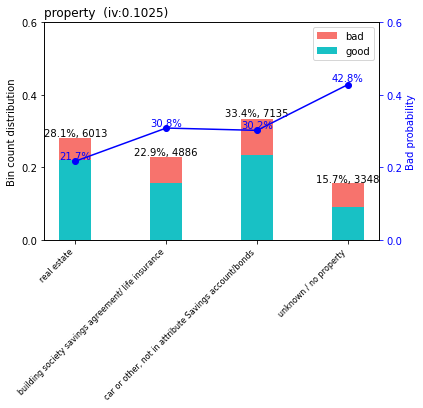

>>> Adjust breaks for (11/12) property?
1: next 
2: yes 
3: back
Selection: 1
-------- 12/12 purpose --------


,variable,bin,brkp,good,bad,badprob
0,purpose,retraining,0,148,22,0.129412
1,purpose,car (used),1,1444,298,0.171068
2,purpose,radio/television,2,3674,1039,0.220454
3,purpose,furniture/equipment,3,2187,1092,0.333028
4,purpose,business,4,1064,547,0.339541
5,purpose,repairs,5,228,126,0.355932
6,purpose,domestic appliances,6,135,76,0.360190
7,purpose,car (new),7,2587,1620,0.385072
8,purpose,education,8,472,343,0.420859
9,purpose,others,9,102,91,0.471503


>>> Current breaks:
'retraining%,%car (used)%,%radio/television','furniture/equipment%,%business%,%repairs%,%domestic appliances','car (new)%,%education%,%others' 



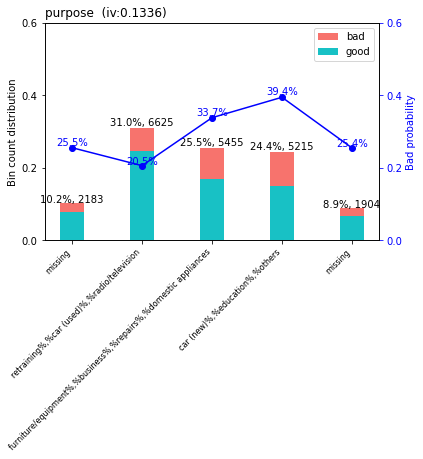

>>> Adjust breaks for (12/12) purpose?
1: next 
2: yes 
3: back
Selection: 1


In [65]:
# review of binning after adjustments
breaks_list = sc.woebin_adj(train, y="will_default", bins=coarse_class_adj, fine_bins=fine_class, adj_all_var=False)

In [72]:
# applying woe transformations on train and test samples 
train_woe = sc.woebin_ply(train, bins=coarse_class_adj)
test_woe = sc.woebin_ply(test, bins=coarse_class_adj)

[INFO] converting into woe values ...


C:\Users\X250\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


[INFO] converting into woe values ...


# 4. TBD Correlation analysis

# 5. Logistic regression

In [ ]:
# target and variables
y_train = train_woe.loc[:,'will_default']
X_train = train_woe.loc[:,train_woe.columns != 'will_default']
y_test = test_woe.loc[:,'will_default']
X_test = test_woe.loc[:,train_woe.columns != 'will_default']

In [ ]:
# logistic regression ------
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
# lr.coef_
# lr.intercept_

In [ ]:
# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# 6. Initial calibration and scorecard points

In [ ]:
# score ------
card = sc.scorecard(coarse_class_adj, lr, X_train.columns, start_zero=True)
# credit score
train_score  = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

In [ ]:
scorecard_points = pd.concat(card, ignore_index=True)
scorecard_points.to_excel("scorecard_points.xlsx", sheet_name='scorecard_points')